# Assignment

## Importing Libraries

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Datasets

In [2]:
cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset

In [3]:
from torch.utils.data import DataLoader
batch_size = 256

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True)

In [4]:
X,y = next(iter(train_iter))

## Creating the test dataset

In [5]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=True)

In [6]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [7]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([256, 3, 32, 32]) The number of input channels is 3
The output labels are as follows tensor([4, 5, 6, 1, 9, 7, 0, 7, 8, 7, 6, 1, 1, 2, 3, 9, 7, 1, 0, 1, 8, 5, 5, 8,
        8, 4, 0, 4, 7, 3, 1, 5, 9, 7, 6, 5, 5, 4, 5, 0, 1, 7, 9, 4, 9, 2, 1, 0,
        9, 9, 3, 3, 1, 1, 3, 6, 5, 1, 0, 9, 7, 5, 6, 3, 0, 8, 4, 7, 4, 7, 4, 0,
        3, 0, 3, 6, 9, 8, 5, 7, 1, 5, 1, 0, 1, 5, 1, 0, 9, 0, 8, 6, 9, 8, 4, 9,
        6, 7, 6, 5, 0, 9, 6, 8, 1, 9, 9, 1, 2, 0, 9, 9, 8, 7, 0, 8, 9, 9, 8, 2,
        6, 9, 1, 4, 6, 6, 9, 0, 0, 4, 7, 7, 8, 5, 6, 3, 1, 6, 7, 4, 1, 6, 3, 8,
        2, 1, 0, 8, 0, 0, 7, 4, 8, 1, 1, 3, 6, 5, 6, 0, 3, 6, 5, 9, 8, 7, 2, 5,
        3, 5, 4, 8, 7, 0, 8, 9, 7, 1, 2, 9, 6, 8, 9, 1, 6, 4, 2, 3, 8, 9, 8, 9,
        2, 4, 6, 2, 6, 9, 5, 2, 4, 2, 8, 9, 5, 7, 1, 0, 8, 5, 2, 9, 4, 9, 9, 8,
        4, 5, 9, 5, 2, 7, 8, 3, 6, 4, 3, 9, 2, 9, 0, 5, 2, 9, 5, 6, 4, 3, 9, 2,
        2, 9, 5, 2, 4, 5, 5, 9, 7, 2, 6, 4, 1, 2, 2, 5])


## Example image

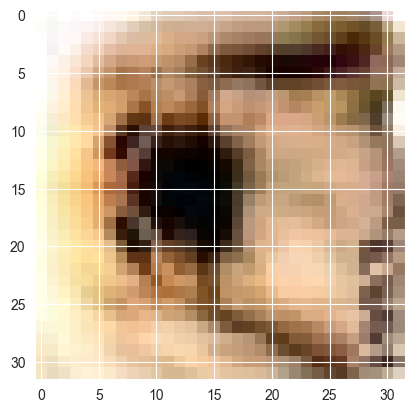

In [44]:
plt.imshow(X[1].T)

## CNN Architecture

- The output features for the basic linear layer has match the number of convolutions
- check if the input to the convolution should be in one or 2 dimensions

In [63]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        #Spatial/Global Pooling for input
        self.spatial_avg_pool = torch.nn.AdaptiveAvgPool2d((24,24))

        # Design the base block Element
        # Create an input linear layer for future combination
        self.linear1 = torch.nn.Linear(in_features=1728,out_features=2)
        self.relu1 = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(num_channels,out_channels=4,kernel_size=5,stride=1,padding=1)
        self.relu2 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(num_channels,out_channels=6,kernel_size=5,stride=1,padding=1)
        self.relu3 = torch.nn.ReLU()

        #Create the dense,classification block creating a FC linear layer to the output
        self.linear2 = torch.nn.Linear(in_features=1152000,out_features=num_outputs)
        self.relu4 = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

        #Define the proportion of neurons to dropout
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self,x):
        # Applying average pooling to downsample the image from 32 ->12
        a = self.spatial_avg_pool(x)

        #Reshape the tensor to allow for matrix multiplication
        a = a.view(a.size(0),-1)

        a = self.linear1(a)
        a = self.dropout(a)
        a = self.relu1(a)

        # Get outputs of each convolution ->RelU layer
        o1 = self.conv1(x)
        o1 = self.relu2(o1)

        o2 = self.conv2(x)
        o2 = self.relu3(o2)

        # Combine the output of each convolutional layer
        O = torch.cat([o1,o2],dim=1)

        # Multiply the matrices to get the output in the correct form
        O_b1 = torch.matmul(O.view(-1,2),a.T) #Output of block 1

        # Move to the dense/classification block
        output = self.linear2(O_b1.view(256,-1))
        output = self.dropout(output)
        output = self.relu4(output)
        output = self.softmax(output)

        return output

In [64]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (spatial_avg_pool): AdaptiveAvgPool2d(output_size=(24, 24))
  (linear1): Linear(in_features=1728, out_features=2, bias=True)
  (relu1): ReLU()
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (linear2): Linear(in_features=1152000, out_features=10, bias=True)
  (relu4): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [65]:
model(X)[0]

tensor([0.0977, 0.0977, 0.0977, 0.0977, 0.0977, 0.0987, 0.0985, 0.1136, 0.1031,
        0.0977], grad_fn=<SelectBackward0>)

In [50]:
X.size(0)

256

In [51]:
test_pool = torch.nn.AdaptiveAvgPool2d((12,12))
t = test_pool(X)
t = t.view(t.size(0),-1)
t.size()

torch.Size([256, 432])

In [52]:
l = torch.nn.Linear(in_features=432,out_features=2)
b =l(t)
r = torch.nn.ReLU()
b = r(b)

In [53]:
b.size()

torch.Size([256, 2])

In [54]:
a = model(X)
a.size()

torch.Size([256, 10])

In [55]:
torch.matmul(a.view(-1,2),b.T).size()

torch.Size([1280, 256])

## Create the metric for calculating accuracy

In [56]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = (y_hat.type(y.dtype) == y)
        return float(torch.sum(cmp))

## Create the model training system

In [66]:
def train_model(model,X,y,X_test,y_test,accuracy,epochs):

    # Create the loss component
    loss = torch.nn.CrossEntropyLoss()

    # Create the optimizer term
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    score_train = []
    score_test = []

    for num_epochs in epochs:
        for epoch in range(num_epochs):
            model.train()
            y_hat = model(X)
            l = loss(y_hat,y)

            optimizer.zero_grad()

            l.backward()
            optimizer.step()

        # Training Accuracy
        score_train.append(accuracy(model(X),y)/len(y))

        # # Test Accuracy
        # torch.no_grad()
        # model.eval()
        # score_test.append(accuracy(model(X_test),y_test)/len(y_test))

    return score_train

In [71]:
epochs = range(0,20)
s1 = train_model(model,X,y,X_test,y_test,accuracy,epochs)

In [72]:
s1

[0.3828125,
 0.41796875,
 0.41796875,
 0.40234375,
 0.34375,
 0.390625,
 0.421875,
 0.42578125,
 0.4375,
 0.41015625,
 0.4609375,
 0.48046875,
 0.43359375,
 0.41796875,
 0.44140625,
 0.4296875,
 0.43359375,
 0.421875,
 0.46484375,
 0.4140625]

Text(0, 0.5, 'Accuracy')

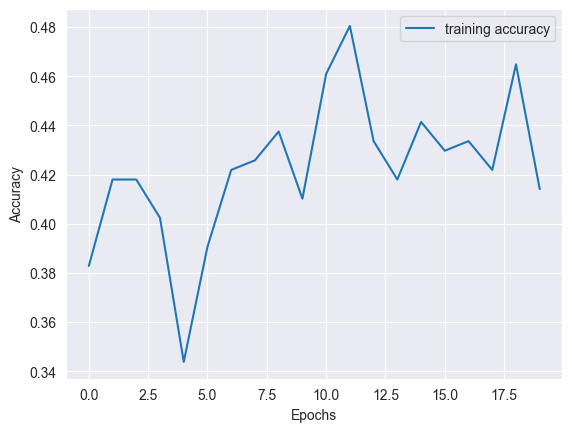

In [73]:
sns.lineplot(x=epochs,y=s1,label='training accuracy')
#sns.lineplot(x=epochs,y=s2,label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')